<a href="https://colab.research.google.com/github/BashayerAB/Arabic_OCR/blob/main/TrainingMINSTdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source Code: https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

In [9]:
import torch

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 102977723.62it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 150292424.10it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26030907.09it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4662390.79it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [12]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [13]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [14]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [15]:
print(train_data.targets.size())

torch.Size([60000])


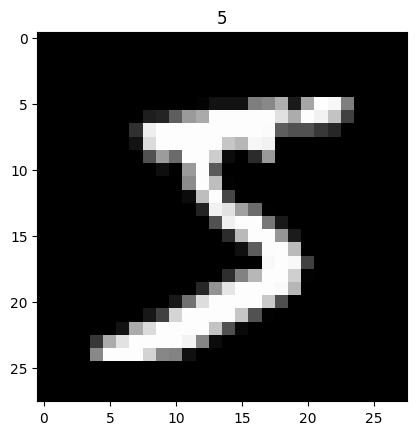

In [16]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

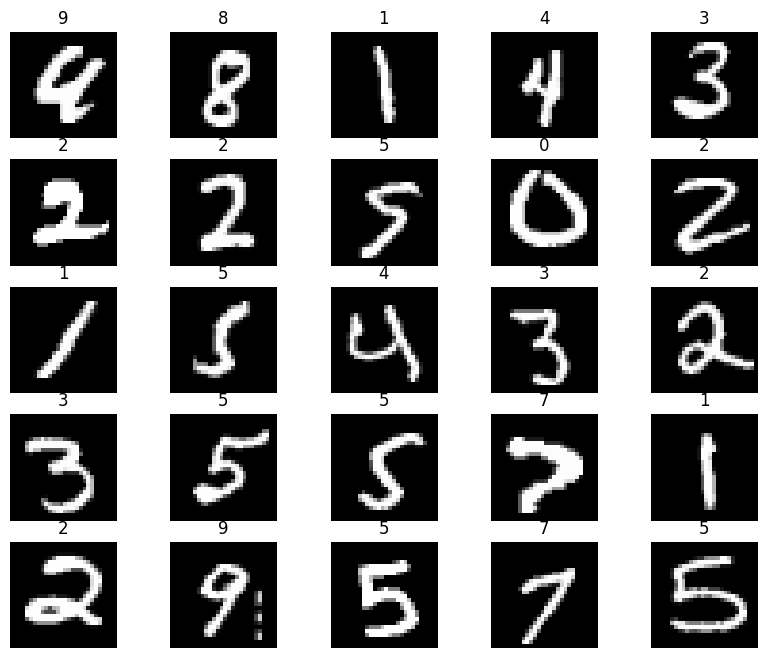

In [28]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [18]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7b4e6a8ea4d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7b4e6a8ea4a0>}

In [19]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #nn.Sequential() pass a list of layers to the constructor. The layers will be executed in the order that they are passed to the constructor
        # This can be useful for defining CNN models, which typically consist of a sequence of convolutional layers
        # , pooling layers, and fully connected layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, # 1 #Number of channels in the input image, here is =1 because our input is a grayscale image.
                out_channels=16, #Number of channels produced by the convolution
                kernel_size=5, # 5 #Size of the convolving kernel, we need to define a kernel which is a small matrix of size 5 * 5.
                stride=1, #Stride is the number of pixels to pass at a time when sliding the convolutional kernel.
                padding=2, #Zero-padding added to both sides of the input. Default: 0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x): # It defines the way we compute our output using the given layers and functions
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [20]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [21]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [22]:
# Learning Rate at which our model updates the weights in the cells each time back-propagation is done.
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [23]:
## training time is 6m and 32s
# training time at 7-10-23 9:33 PM is 4 m 31s
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders): #num_epochs: Number of times our model will go through the entire training dataset

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass

        pass


    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0602
Epoch [1/10], Step [200/600], Loss: 0.1664
Epoch [1/10], Step [300/600], Loss: 0.0810
Epoch [1/10], Step [400/600], Loss: 0.0182
Epoch [1/10], Step [500/600], Loss: 0.0570
Epoch [1/10], Step [600/600], Loss: 0.0629
Epoch [2/10], Step [100/600], Loss: 0.0589
Epoch [2/10], Step [200/600], Loss: 0.1277
Epoch [2/10], Step [300/600], Loss: 0.0629
Epoch [2/10], Step [400/600], Loss: 0.0840
Epoch [2/10], Step [500/600], Loss: 0.1604
Epoch [2/10], Step [600/600], Loss: 0.0162
Epoch [3/10], Step [100/600], Loss: 0.0086
Epoch [3/10], Step [200/600], Loss: 0.0470
Epoch [3/10], Step [300/600], Loss: 0.0090
Epoch [3/10], Step [400/600], Loss: 0.1027
Epoch [3/10], Step [500/600], Loss: 0.0635
Epoch [3/10], Step [600/600], Loss: 0.0345
Epoch [4/10], Step [100/600], Loss: 0.0589
Epoch [4/10], Step [200/600], Loss: 0.0791
Epoch [4/10], Step [300/600], Loss: 0.0167
Epoch [4/10], Step [400/600], Loss: 0.0616
Epoch [4/10], Step [500/600], Loss: 0.1811
Epoch [4/10

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


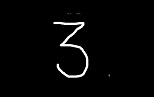

In [2]:
import PIL.Image
import torch
import numpy as np
# Load the image
image = PIL.Image.open('/content/drive/My Drive/3.jpg')
image


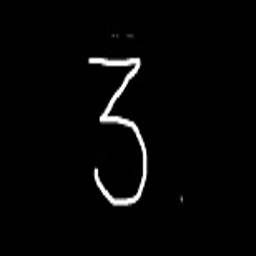

In [3]:
s = 255
image.resize((256,256))

In [47]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(5),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize( (0.5,),(0.5)                     #[5]
 #mean=[0.485, 0.456, 0.406],                #[6]
 #std=[0.229, 0.224, 0.225]                  #[7]
 ),
 transforms.Grayscale()])


In [48]:
img_t = transform(image)
batch_t = torch.unsqueeze(img_t, 0)

In [49]:
cnn.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [50]:
out = cnn(batch_t)
print(out.shape)

RuntimeError: ignored

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    pass
test()

Test Accuracy of the model on the 10000 test images: 0.97


In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [ ]:
actual_number = lbls[:10].numpy()
actual_number

array([8, 6, 3, 2, 1, 7, 5, 5, 4, 4])

In [ ]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [8 6 3 2 1 7 5 5 4 4]
Actual number: [8 6 3 2 1 7 5 5 4 4]
